In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from thefuzz import process as fzproc
from thefuzz import fuzz

import pathlib as plb

In [2]:
WORK_DIR = plb.Path().resolve().parent
INPUT_DIR = WORK_DIR / "data_inputs"
OUTPUT_DIR = WORK_DIR / "data_outputs"
NOTEBOOK_DIR = WORK_DIR / "notebooks"
SCRIPTS_DIR = WORK_DIR / "scripts"
BOUNDS_DIR = WORK_DIR.parent.parent / "E- Administrative Boundaries" / "phl_adm_psa_namria_20231106_shp"

In [3]:
fp_cph_2b = INPUT_DIR / "2020 Report 2B_Attachment_Housing.xlsx"
assert fp_cph_2b.exists()

In [4]:
fp_ab3 = BOUNDS_DIR / "phl_admbnda_adm3_psa_namria_20231106.shp"
assert fp_ab3.exists()

In [5]:
# drinking_water_sources = pd.read_excel(
#     fp_cph_2b,
#     sheet_name="T4",
#     header=5
# ).columns.values.tolist()

# drinking_water_sources = [source for source in drinking_water_sources if not(source.startswith("Unnamed"))]

# drinking_water_sources

In [6]:
water_sources_col_names = [
    "faucet_own",
    "faucet_shared",
    "deepwell_own",
    "deepwell_shared",
    "shallow_well",
    "openwell_protected",
    "openwell_unprotected",
    "spring_protected",
    "spring_unprotected",
    "rain_water",
    "surface_water",
    "peddler",
    "refilling_station",
    "bottled_water",
    "others"
]

In [7]:
dws_col_names = water_sources_col_names.copy()
for col in ["n_households", "geolocation", "loc_marker"]:
    dws_col_names.insert(0, col)

df_drinking_water = pd.read_excel(
    fp_cph_2b,
    sheet_name="T4",
    header=11,
    names=dws_col_names,
    nrows=1742
)

is_philippines = df_drinking_water["geolocation"] == "PHILIPPINES"
df_drinking_water = df_drinking_water[~is_philippines]

df_drinking_water = df_drinking_water.dropna(how="all")

df_drinking_water.head(10)

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
1,R,NATIONAL CAPITAL REGION (NCR),3494249,1093770,147000,21223,7260,2134,2786,1333,1760,403,3650,5309,9537,2093579,69871,34633
2,M,CITY OF MANILA,483261,118315,27775,2809,1304,310,273,113,385,51,484,518,2135,313194,4670,10924
3,M,CITY OF MANDALUYONG,116505,32880,4687,426,63,150,26,10,21,21,153,133,159,73490,3857,429
4,M,CITY OF MARIKINA,104404,47226,4447,762,70,64,33,43,48,10,117,177,110,50298,627,373
5,M,CITY OF PASIG,212864,89493,6025,1428,240,139,271,96,90,44,462,436,338,110848,1803,1150
6,M,QUEZON CITY,738330,309249,36489,4594,2719,633,575,415,481,74,1098,1489,827,357899,3321,18467
7,M,CITY OF SAN JUAN,31400,12578,1523,341,44,103,15,6,5,5,34,50,14,16075,522,84
8,M,CITY OF CALOOCAN,404130,176330,23001,3623,1258,381,625,256,242,105,344,767,806,193686,1988,718
9,M,CITY OF MALABON,94188,20472,4924,523,74,37,44,0,45,0,29,89,432,66771,404,343
10,M,CITY OF NAVOTAS,63051,12995,3523,437,30,10,40,24,0,0,80,66,367,45116,265,97


In [8]:
df_drinking_water.tail()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
1737,M,MIDSAYAP CLUSTER II,4274,212,286,552,1347,162,513,218,5,5,0,0,822,154,0,0
1738,M,PIGKAWAYAN CLUSTER,4356,192,560,349,1315,325,232,283,5,0,0,26,669,389,10,0
1739,M,PIKIT CLUSTER I,8935,176,143,3128,4133,558,119,14,31,10,5,5,127,413,73,0
1740,M,PIKIT CLUSTER II,7978,34,39,739,2894,716,1922,781,17,5,0,31,542,253,5,0
1741,M,PIKIT CLUSTER III,6566,16,494,1250,2867,485,607,659,108,5,0,0,5,68,0,0


In [9]:
is_region = df_drinking_water["loc_marker"] == "R"
df_drinking_water.loc[is_region, "region"] = df_drinking_water.loc[is_region, "geolocation"]

df_drinking_water["region"] = df_drinking_water["region"].ffill()
df_drinking_water = df_drinking_water[~is_region]

df_drinking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region
2,M,CITY OF MANILA,483261,118315,27775,2809,1304,310,273,113,385,51,484,518,2135,313194,4670,10924,NATIONAL CAPITAL REGION (NCR)
3,M,CITY OF MANDALUYONG,116505,32880,4687,426,63,150,26,10,21,21,153,133,159,73490,3857,429,NATIONAL CAPITAL REGION (NCR)
4,M,CITY OF MARIKINA,104404,47226,4447,762,70,64,33,43,48,10,117,177,110,50298,627,373,NATIONAL CAPITAL REGION (NCR)
5,M,CITY OF PASIG,212864,89493,6025,1428,240,139,271,96,90,44,462,436,338,110848,1803,1150,NATIONAL CAPITAL REGION (NCR)
6,M,QUEZON CITY,738330,309249,36489,4594,2719,633,575,415,481,74,1098,1489,827,357899,3321,18467,NATIONAL CAPITAL REGION (NCR)


In [10]:
is_province = df_drinking_water["loc_marker"] == "P"
df_drinking_water.loc[is_province, "province"] = df_drinking_water.loc[is_province, "geolocation"]

df_drinking_water["province"] = df_drinking_water["province"].ffill()
df_drinking_water = df_drinking_water[~is_province]

df_drinking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region,province
2,M,CITY OF MANILA,483261,118315,27775,2809,1304,310,273,113,385,51,484,518,2135,313194,4670,10924,NATIONAL CAPITAL REGION (NCR),NaN
3,M,CITY OF MANDALUYONG,116505,32880,4687,426,63,150,26,10,21,21,153,133,159,73490,3857,429,NATIONAL CAPITAL REGION (NCR),NaN
4,M,CITY OF MARIKINA,104404,47226,4447,762,70,64,33,43,48,10,117,177,110,50298,627,373,NATIONAL CAPITAL REGION (NCR),NaN
5,M,CITY OF PASIG,212864,89493,6025,1428,240,139,271,96,90,44,462,436,338,110848,1803,1150,NATIONAL CAPITAL REGION (NCR),NaN
6,M,QUEZON CITY,738330,309249,36489,4594,2719,633,575,415,481,74,1098,1489,827,357899,3321,18467,NATIONAL CAPITAL REGION (NCR),NaN


In [11]:
ncr_districts = {
    "METROPOLITAN MANILA FIRST DISTRICT": ["CITY OF MANILA"],
    "METROPOLITAN MANILA SECOND DISTRICT": [
        "CITY OF MANDALUYONG",
        "CITY OF MARIKINA",
        "CITY OF PASIG",
        "QUEZON CITY",
        "CITY OF SAN JUAN"
    ],
    "METROPOLITAN MANILA THIRD DISTRICT": [
        "CITY OF CALOOCAN",
        "CITY OF MALABON",
        "CITY OF NAVOTAS",
        "CITY OF VALENZUELA"
    ],
    "METROPOLITAN MANILA FOURTH DISTRICT": [
        "CITY OF LAS PIÑAS",
        "CITY OF MAKATI",
        "CITY OF MUNTINLUPA",
        "CITY OF PARAÑAQUE",
        "PASAY CITY",
        "PATEROS",
        "CITY OF TAGUIG"
    ]
}

# for district in ncr_districts:
#     print([city for city in ncr_districts[district]])

for district in ncr_districts:
    is_in_district = df_drinking_water["geolocation"].isin(ncr_districts[district])
    df_drinking_water.loc[is_in_district, "province"] = district

df_drinking_water.head()

,loc_marker,geolocation,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others,region,province
2,M,CITY OF MANILA,483261,118315,27775,2809,1304,310,273,113,385,51,484,518,2135,313194,4670,10924,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA FIRST DISTRICT
3,M,CITY OF MANDALUYONG,116505,32880,4687,426,63,150,26,10,21,21,153,133,159,73490,3857,429,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
4,M,CITY OF MARIKINA,104404,47226,4447,762,70,64,33,43,48,10,117,177,110,50298,627,373,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
5,M,CITY OF PASIG,212864,89493,6025,1428,240,139,271,96,90,44,462,436,338,110848,1803,1150,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT
6,M,QUEZON CITY,738330,309249,36489,4594,2719,633,575,415,481,74,1098,1489,827,357899,3321,18467,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT


In [12]:
df_drinking_water = df_drinking_water.drop(columns=["loc_marker"]) \
                    .rename(columns={"geolocation": "municipality"})

geolocation_levels = ["region", "province", "municipality"]

df_drinking_water = df_drinking_water[geolocation_levels + ["n_households"] + water_sources_col_names]

df_drinking_water.head()

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
2,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA FIRST DISTRICT,CITY OF MANILA,483261,118315,27775,2809,1304,310,273,113,385,51,484,518,2135,313194,4670,10924
3,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF MANDALUYONG,116505,32880,4687,426,63,150,26,10,21,21,153,133,159,73490,3857,429
4,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF MARIKINA,104404,47226,4447,762,70,64,33,43,48,10,117,177,110,50298,627,373
5,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF PASIG,212864,89493,6025,1428,240,139,271,96,90,44,462,436,338,110848,1803,1150
6,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,QUEZON CITY,738330,309249,36489,4594,2719,633,575,415,481,74,1098,1489,827,357899,3321,18467


In [13]:
is_interim = df_drinking_water["province"] == "INTERIM PROVINCE 1"
df_drinking_water.loc[is_interim, "province"] = "SPECIAL GEOGRAPHIC AREA"

df_drinking_water.tail()

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
1737,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,MIDSAYAP CLUSTER II,4274,212,286,552,1347,162,513,218,5,5,0,0,822,154,0,0
1738,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIGKAWAYAN CLUSTER,4356,192,560,349,1315,325,232,283,5,0,0,26,669,389,10,0
1739,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIKIT CLUSTER I,8935,176,143,3128,4133,558,119,14,31,10,5,5,127,413,73,0
1740,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIKIT CLUSTER II,7978,34,39,739,2894,716,1922,781,17,5,0,31,542,253,5,0
1741,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIKIT CLUSTER III,6566,16,494,1250,2867,485,607,659,108,5,0,0,5,68,0,0


In [14]:
is_city_isabela = df_drinking_water["municipality"].str.contains("CITY OF ISABELA")
df_drinking_water.loc[is_city_isabela, "province"] = "CITY OF ISABELA (NOT A PROVINCE)"

In [15]:
including_excluding = (df_drinking_water["province"].str.contains(r"^.* \(including .*\)$", regex=True)) \
                    | (df_drinking_water["province"].str.contains(r"^.* \(excluding .*\)$", regex=True))

df_drinking_water.loc[including_excluding, "province"] = df_drinking_water.loc[including_excluding, "province"].str.replace(r"^(.*) \(.*\)$", "\\1", regex=True)

df_drinking_water[including_excluding]

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,openwell_protected,openwell_unprotected,spring_protected,spring_unprotected,rain_water,surface_water,peddler,refilling_station,bottled_water,others
1610,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,CITY OF LAMITAN (Capital),19353,5214,4339,511,926,135,4251,1008,397,430,0,109,169,1845,16,5
1611,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,LANTAWAN,5758,368,2036,87,741,78,1274,42,1009,7,21,11,5,15,0,66
1612,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,MALUSO,7195,3350,1811,81,147,19,606,57,306,110,15,55,270,275,38,56
1613,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,SUMISIP,8445,805,3149,544,1167,98,1097,255,787,85,5,361,5,65,21,0
1614,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,TIPO-TIPO,4195,224,1932,54,106,16,115,696,315,244,0,370,5,86,30,0
1615,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,TUBURAN,4011,147,293,196,204,19,1138,1433,39,492,0,19,10,7,14,0
1616,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,AKBAR,3621,36,85,123,111,37,920,2178,6,0,0,0,0,124,0,0
1617,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,AL-BARKA,4221,31,215,223,326,20,271,1763,292,676,0,379,10,5,10,0
1618,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,HADJI MOHAMMAD AJUL,3818,58,11,116,455,26,1525,1553,10,5,0,0,0,59,0,0
1619,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,UNGKAYA PUKAN,4039,975,1827,41,410,20,39,257,189,103,0,48,88,5,38,0


In [16]:
level_3_water_sources = [
    "faucet_own",
    "deepwell_own"
]

level_2_water_sources = [
    "faucet_shared",
    "deepwell_shared",
    "shallow_well"
]

safe_private_sources = [
    "refilling_station",
    "bottled_water"
]

target_cols_in_safe_water = level_3_water_sources + level_2_water_sources + safe_private_sources + geolocation_levels + ["n_households"]

# df_safe_water = df_drinking_water.copy(deep=True)[["geolocation", "n_households"] + level_3_water_sources + level_2_water_sources + ["bottled_water"]]
df_safe_water = df_drinking_water.copy(deep=True) \
                .drop(columns=[
                    col for col in df_drinking_water.columns.values if col not in target_cols_in_safe_water
                ])
df_safe_water["pc_level_3"] = round(df_safe_water[level_3_water_sources].sum(axis=1) / df_safe_water["n_households"], 5)
df_safe_water["pc_level_2"] = round(df_safe_water[level_2_water_sources].sum(axis=1) / df_safe_water["n_households"], 5)
df_safe_water["pc_safe_private"] = round(df_safe_water[safe_private_sources].sum(axis=1) / df_safe_water["n_households"], 5)
df_safe_water["pc_safe"] = df_safe_water["pc_level_3"] + df_safe_water["pc_level_2"] + df_safe_water["pc_safe_private"]
df_safe_water["pc_unsafe"] = 1.0 - df_safe_water["pc_safe"]

# pd.set_option("display.max_rows", None)

df_safe_water.sample(10)

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe
1171,REGION VIII (EASTERN VISAYAS),NORTHERN SAMAR,GAMAY,5696,213,2238,369,823,15,1622,11,0.10218,0.54003,0.28669,0.92890,0.07110
1021,REGION VII (CENTRAL VISAYAS),CEBU,BORBON,9663,1171,717,40,159,70,5372,247,0.12532,0.09790,0.58150,0.80472,0.19528
1619,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,BASILAN,UNGKAYA PUKAN,4039,975,1827,41,410,20,5,38,0.25155,0.55880,0.01065,0.82100,0.17900
1381,REGION X (NORTHERN MINDANAO),MISAMIS OCCIDENTAL,CONCEPCION,2271,426,958,0,0,0,12,17,0.18758,0.42184,0.01277,0.62219,0.37781
1121,REGION VIII (EASTERN VISAYAS),LEYTE,ABUYOG,14895,3020,3794,260,543,220,5251,128,0.22021,0.30594,0.36113,0.88728,0.11272
363,REGION III (CENTRAL LUZON),BULACAN,PLARIDEL,29011,2913,762,201,180,41,24409,378,0.10734,0.03388,0.85440,0.99562,0.00438
317,REGION II (CAGAYAN VALLEY),NUEVA VIZCAYA,DUPAX DEL SUR,5120,1108,171,230,344,64,1445,20,0.26133,0.11309,0.28613,0.66055,0.33945
540,REGION IV-A (CALABARZON),LAGUNA,LILIW,10706,5354,494,50,83,5,4600,19,0.50476,0.05436,0.43144,0.99056,0.00944
611,REGION IV-A (CALABARZON),RIZAL,RODRIGUEZ (MONTALBAN),100819,24252,3919,1793,1289,325,63199,813,0.25833,0.05488,0.63492,0.94813,0.05187
797,REGION V (BICOL REGION),MASBATE,PLACER,13197,225,49,55,21,20,7120,21,0.02122,0.00682,0.54111,0.56915,0.43085


In [17]:
df_safe_water["address"] = df_safe_water["province"] + ", " + df_safe_water["municipality"]
df_safe_water

,region,province,municipality,n_households,faucet_own,faucet_shared,deepwell_own,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe,address
2,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA FIRST DISTRICT,CITY OF MANILA,483261,118315,27775,2809,1304,310,313194,4670,0.25064,0.06081,0.65775,0.96920,0.03080,"METROPOLITAN MANILA FIRST DISTRICT, CITY OF MA..."
3,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF MANDALUYONG,116505,32880,4687,426,63,150,73490,3857,0.28588,0.04206,0.66389,0.99183,0.00817,"METROPOLITAN MANILA SECOND DISTRICT, CITY OF M..."
4,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF MARIKINA,104404,47226,4447,762,70,64,50298,627,0.45964,0.04388,0.48777,0.99129,0.00871,"METROPOLITAN MANILA SECOND DISTRICT, CITY OF M..."
5,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,CITY OF PASIG,212864,89493,6025,1428,240,139,110848,1803,0.42713,0.03008,0.52922,0.98643,0.01357,"METROPOLITAN MANILA SECOND DISTRICT, CITY OF P..."
6,NATIONAL CAPITAL REGION (NCR),METROPOLITAN MANILA SECOND DISTRICT,QUEZON CITY,738330,309249,36489,4594,2719,633,357899,3321,0.42507,0.05396,0.48924,0.96827,0.03173,"METROPOLITAN MANILA SECOND DISTRICT, QUEZON CITY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,MIDSAYAP CLUSTER II,4274,212,286,552,1347,162,154,0,0.17876,0.41998,0.03603,0.63477,0.36523,"SPECIAL GEOGRAPHIC AREA, MIDSAYAP CLUSTER II"
1738,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIGKAWAYAN CLUSTER,4356,192,560,349,1315,325,389,10,0.12420,0.50505,0.09160,0.72085,0.27915,"SPECIAL GEOGRAPHIC AREA, PIGKAWAYAN CLUSTER"
1739,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIKIT CLUSTER I,8935,176,143,3128,4133,558,413,73,0.36978,0.54102,0.05439,0.96519,0.03481,"SPECIAL GEOGRAPHIC AREA, PIKIT CLUSTER I"
1740,BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANA...,SPECIAL GEOGRAPHIC AREA,PIKIT CLUSTER II,7978,34,39,739,2894,716,253,5,0.09689,0.45738,0.03234,0.58661,0.41339,"SPECIAL GEOGRAPHIC AREA, PIKIT CLUSTER II"


<Axes: ylabel='Frequency'>

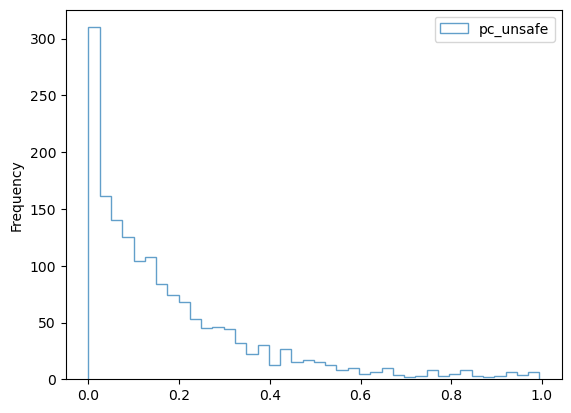

In [18]:
df_safe_water.plot(
    kind="hist",
    y="pc_unsafe",
    alpha=0.7,
    histtype="step",
    bins=40,
    # bw_method=0.3,
    # ind=300,
    # xlim=[0.0, 1.0]
)

In [19]:
gdf_ab3 = gpd.read_file(fp_ab3)
gdf_ab3.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.423604,0.009506,111.143026,"POLYGON ((120.96915 18.51012, 120.95867 18.463..."
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.309136,0.004725,55.303195,"POLYGON ((120.66821 18.28705, 120.66441 18.282..."
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.599295,0.006880,80.683970,"POLYGON ((120.47814 17.97717, 120.47816 17.977..."
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.483066,0.009843,115.059041,"POLYGON ((120.81318 18.53457, 120.81358 18.533..."
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.613500,0.013493,158.123132,"POLYGON ((120.61242 18.10947, 120.61200 18.106..."


In [20]:
ab2_names = gdf_ab3["ADM2_EN"].unique()
ab2_names

array(['Ilocos Norte', 'Ilocos Sur', 'La Union', 'Pangasinan', 'Batanes',
       'Cagayan', 'Isabela', 'Nueva Vizcaya', 'Quirino', 'Bataan',
       'Bulacan', 'Nueva Ecija', 'Pampanga', 'Tarlac', 'Zambales',
       'Aurora', 'Batangas', 'Cavite', 'Laguna', 'Quezon', 'Rizal',
       'Albay', 'Camarines Norte', 'Camarines Sur', 'Catanduanes',
       'Masbate', 'Sorsogon', 'Aklan', 'Antique', 'Capiz', 'Iloilo',
       'Negros Occidental', 'Guimaras', 'Bohol', 'Cebu',
       'Negros Oriental', 'Siquijor', 'Eastern Samar', 'Leyte',
       'Northern Samar', 'Samar (Western Samar)', 'Southern Leyte',
       'Biliran', 'Zamboanga del Norte', 'Zamboanga del Sur',
       'Zamboanga Sibugay', 'City of Isabela (not a province)',
       'Bukidnon', 'Camiguin', 'Lanao del Norte', 'Misamis Occidental',
       'Misamis Oriental', 'Davao del Norte', 'Davao del Sur',
       'Davao Oriental', 'Davao de Oro (Compostela Valley)',
       'Davao Occidental', 'Cotabato (North Cotabato)', 'South Cotabato',
   

In [21]:
is_special_area = gdf_ab3["ADM2_EN"] == "Special Geographic Area"

gdf_ab3.loc[is_special_area, "ADM3_EN"] = gdf_ab3.loc[is_special_area, "ADM3_EN"].str.replace("Special Geographic Area - ", "")

In [22]:
is_maguindanao = gdf_ab3["ADM2_EN"].str.contains(r"^Maguindanao", regex=True)

gdf_ab3.loc[is_maguindanao, "ADM2_EN"] = gdf_ab3.loc[is_maguindanao, "ADM2_EN"].str.replace(r"^(Maguindanao).*", "Maguindanao", regex=True)
gdf_ab3[is_maguindanao].sample(10)

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry
1632,Datu Salibo,PH1908836,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.307476,0.002405,29.391968,"POLYGON ((124.52446 6.99173, 124.52457 6.98772..."
1603,Kabuntalan (Tumbao),PH1908714,Maguindanao,PH19087,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,Tumbao,0.496216,0.007171,87.607098,"POLYGON ((124.33906 7.17435, 124.33989 7.17339..."
1615,Pagalungan,PH1908810,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,1.155966,0.016227,198.305818,"MULTIPOLYGON (((124.71735 7.13676, 124.71736 7..."
1620,Mamasapano,PH1908820,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.359587,0.002961,36.187836,"POLYGON ((124.53370 6.95486, 124.53500 6.95447..."
1610,Ampatuan,PH1908801,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.855622,0.018165,222.067354,"POLYGON ((124.51314 6.75598, 124.51319 6.75578..."
1601,Parang,PH1908711,Maguindanao,PH19087,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,1.074042,0.011807,144.172687,"MULTIPOLYGON (((124.34805 7.38683, 124.34770 7..."
1619,Gen. S.K. Pendatun,PH1908819,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.519554,0.011478,140.308559,"POLYGON ((124.80411 6.88234, 124.80600 6.88100..."
1617,Talayan,PH1908816,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.905138,0.011158,136.365785,"POLYGON ((124.42760 7.04161, 124.42218 7.03204..."
1623,Guindulungan,PH1908825,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.663966,0.009270,113.290991,"POLYGON ((124.45242 6.99646, 124.42931 6.98258..."
1612,Datu Paglas,PH1908805,Maguindanao,PH19088,Bangsamoro Autonomous Region In Muslim Mindana...,PH19,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.640563,0.011749,143.647463,"POLYGON ((125.00774 6.73411, 125.00681 6.71187..."


In [23]:
gdf_ab3["ADDR"] = gdf_ab3["ADM2_EN"] + ", " + gdf_ab3["ADM3_EN"]
gdf_ab3.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.423604,0.009506,111.143026,"POLYGON ((120.96915 18.51012, 120.95867 18.463...","Ilocos Norte, Adams"
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.309136,0.004725,55.303195,"POLYGON ((120.66821 18.28705, 120.66441 18.282...","Ilocos Norte, Bacarra"
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.599295,0.006880,80.683970,"POLYGON ((120.47814 17.97717, 120.47816 17.977...","Ilocos Norte, Badoc"
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.483066,0.009843,115.059041,"POLYGON ((120.81318 18.53457, 120.81358 18.533...","Ilocos Norte, Bangui"
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.613500,0.013493,158.123132,"POLYGON ((120.61242 18.10947, 120.61200 18.106...","Ilocos Norte, City of Batac"


In [24]:
unique_addresses = df_safe_water["address"].unique()

gdf_ab3["MATCH"] = gdf_ab3["ADDR"].apply(
    lambda x: fzproc.extractOne(
        x, 
        unique_addresses, 
        scorer=fuzz.WRatio, 
        score_cutoff=80
    )
)

gdf_ab3[gdf_ab3["MATCH"].isna()]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH


Handling duplicate fuzzy address matches:

Case 1: Duplicate address, different scores
- For each unique address in the list of duplicated addresses...
- Re-match the row with the LOWER score using a different scorer (token sort?)
- Implied: RETAIN the row with the HIGHER score

Case 2: Both address and score are duplicated
- For each unique address in the list of doubly duplicated addresses...
- Re-match BOTH rows using a different scorer (token sort?)

In [25]:
is_duplicated = gdf_ab3["MATCH"].str[0].duplicated(keep=False)

is_double_duplicated = gdf_ab3["MATCH"].duplicated(keep=False)

is_single_duplicated = is_duplicated & ~is_double_duplicated

# Case 1: is_duplicated & ~is_double_duplicated
duplicated_addresses = gdf_ab3.loc[is_single_duplicated, "MATCH"].str[0].unique()
duplicated_addresses

for address in duplicated_addresses:
    has_address = gdf_ab3["MATCH"].str[0] == address
    
    lower_score = gdf_ab3.loc[has_address, "MATCH"].str[1].astype(int).min()
    
    has_lower_score = gdf_ab3["MATCH"].str[1] == lower_score

    must_rematch = has_address & has_lower_score

    gdf_ab3.loc[must_rematch, "MATCH"] = gdf_ab3.loc[must_rematch, "ADDR"].apply(
        lambda x: fzproc.extractOne(
            x,
            unique_addresses,
            scorer=fuzz.partial_token_sort_ratio,
            score_cutoff=80
        )
    )

gdf_ab3[is_single_duplicated]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH
232,City of Baliwag,PH0301403,Bulacan,PH03014,Region III (Central Luzon),PH03,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.404831,0.003845,45.759894,"POLYGON ((120.92252 14.96375, 120.92176 14.962...","Bulacan, City of Baliwag","(BULACAN, BALIUAG, 93)"
354,City of Calaca,PH0401007,Batangas,PH04010,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.485431,0.009609,114.860453,"POLYGON ((120.85728 14.03536, 120.85884 14.020...","Batangas, City of Calaca","(BATANGAS, CALACA, 100)"
361,Lipa City,PH0401014,Batangas,PH04010,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.781148,0.015999,191.281851,"POLYGON ((121.23927 13.99051, 121.24250 13.987...","Batangas, Lipa City","(BATANGAS, CITY OF LIPA, 95)"
1189,Davao City,PH1102402,Davao del Sur,PH11024,Region XI (Davao Region),PH11,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,2.808307,0.191718,2341.425940,"POLYGON ((125.54361 7.56545, 125.54331 7.54805...","Davao del Sur, Davao City","(DAVAO DEL SUR, CITY OF DAVAO, 93)"
1190,City of Digos (Capital),PH1102403,Davao del Sur,PH11024,Region XI (Davao Region),PH11,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.813907,0.021731,265.630989,"POLYGON ((125.38655 6.77894, 125.38655 6.77894...","Davao del Sur, City of Digos (Capital)","(DAVAO DEL SUR, CITY OF DIGOS (Capital), 100)"
1275,City of Manila,PH1303901,Metropolitan Manila First District,PH13039,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.600152,0.003520,41.960090,"POLYGON ((120.98508 14.63998, 120.98568 14.639...","Metropolitan Manila First District, City of Ma...","(METROPOLITAN MANILA FIRST DISTRICT, CITY OF M..."


In [26]:
double_duplicated_addresses = gdf_ab3.loc[is_double_duplicated, "MATCH"].str[0].unique()

for address in double_duplicated_addresses:
    has_address = gdf_ab3["MATCH"].str[0] == address

    gdf_ab3.loc[has_address, "MATCH"] = gdf_ab3.loc[has_address, "ADDR"].apply(
        lambda x: fzproc.extractOne(
            x,
            unique_addresses,
            scorer=fuzz.partial_token_sort_ratio,
            score_cutoff=80
        )
    )

gdf_ab3[is_double_duplicated]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH
384,Bacoor City,PH0402103,Cavite,PH04021,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.416209,0.004108,49.010326,"POLYGON ((121.01078 14.37485, 121.01068 14.374...","Cavite, Bacoor City","(CAVITE, CITY OF BACOOR, 100)"
386,Cavite City,PH0402105,Cavite,PH04021,Region IV-A (Calabarzon),PH04,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,0.487507,0.000995,11.873715,"MULTIPOLYGON (((120.88907 14.45577, 120.88747 ...","Cavite, Cavite City","(CAVITE, CITY OF CAVITE, 100)"
1052,Pagadian City (Capital),PH0907322,Zamboanga del Sur,PH09073,Region IX (Zamboanga Peninsula),PH09,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,1.239542,0.022526,274.721828,"MULTIPOLYGON (((123.26079 7.96602, 123.29459 7...","Zamboanga del Sur, Pagadian City (Capital)","(ZAMBOANGA DEL SUR, CITY OF PAGADIAN (Capital)..."
1059,Zamboanga City,PH0907332,Zamboanga del Sur,PH09073,Region IX (Zamboanga Peninsula),PH09,Philippines (the),PH,2022-11-09,2023-11-06,None,None,None,4.719512,0.122560,1497.154804,"MULTIPOLYGON (((122.05710 6.87274, 122.05724 6...","Zamboanga del Sur, Zamboanga City","(ZAMBOANGA DEL SUR, CITY OF ZAMBOANGA, 91)"


In [27]:
gdf_ab3[gdf_ab3["MATCH"].duplicated(keep=False)]

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,ADDR,MATCH


In [28]:
gdf_ab3["ADM1_EN"].unique()

array(['Region I (Ilocos Region)', 'Region II (Cagayan Valley)',
       'Region III (Central Luzon)', 'Region IV-A (Calabarzon)',
       'Region V (Bicol Region)', 'Region VI (Western Visayas)',
       'Region VII (Central Visayas)', 'Region VIII (Eastern Visayas)',
       'Region IX (Zamboanga Peninsula)', 'Region X (Northern Mindanao)',
       'Region XI (Davao Region)', 'Region XII (Soccsksargen)',
       'National Capital Region (NCR)',
       'Cordillera Administrative Region (CAR)', 'Region XIII (Caraga)',
       'Mimaropa Region',
       'Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)'],
      dtype=object)

In [29]:
target_region = "Western Visayas"
is_in_region = gdf_ab3["ADM1_EN"].str.contains(target_region)
gdf_ab3.loc[is_in_region, ["ADDR", "MATCH"]]

,ADDR,MATCH
604,"Aklan, Altavas","(AKLAN, ALTAVAS, 100)"
605,"Aklan, Balete","(AKLAN, BALETE, 100)"
606,"Aklan, Banga","(AKLAN, BANGA, 100)"
607,"Aklan, Batan","(AKLAN, BATAN, 100)"
608,"Aklan, Buruanga","(AKLAN, BURUANGA, 100)"
...,...,...
732,"Guimaras, Buenavista","(GUIMARAS, BUENAVISTA, 100)"
733,"Guimaras, Jordan (Capital)","(GUIMARAS, JORDAN (CAPITAL), 100)"
734,"Guimaras, Nueva Valencia","(GUIMARAS, NUEVA VALENCIA, 100)"
735,"Guimaras, San Lorenzo","(GUIMARAS, SAN LORENZO, 100)"


In [30]:
target_province = "Bulacan"
is_in_province = gdf_ab3["ADM2_EN"].str.contains(target_province)
gdf_ab3.loc[is_in_province, ["ADDR", "MATCH"]]

,ADDR,MATCH
230,"Bulacan, Angat","(BULACAN, ANGAT, 100)"
231,"Bulacan, Balagtas (Bigaa)","(BULACAN, BALAGTAS (BIGAA), 100)"
232,"Bulacan, City of Baliwag","(BULACAN, BALIUAG, 93)"
233,"Bulacan, Bocaue","(BULACAN, BOCAUE, 100)"
234,"Bulacan, Bulacan","(BULACAN, BULACAN, 100)"
235,"Bulacan, Bustos","(BULACAN, BUSTOS, 100)"
236,"Bulacan, Calumpit","(BULACAN, CALUMPIT, 100)"
237,"Bulacan, Guiguinto","(BULACAN, GUIGUINTO, 100)"
238,"Bulacan, Hagonoy","(BULACAN, HAGONOY, 100)"
239,"Bulacan, City of Malolos (Capital)","(BULACAN, CITY OF MALOLOS (Capital), 100)"


In [31]:
fuzz.partial_token_set_ratio("Bulacan, City of Baliwag", "BULACAN, BALIUAG")

100

In [32]:
fuzz.partial_token_sort_ratio("Cavite, Cavite City", "CAVITE, CITY OF BACOOR")

73

In [33]:
ratios = [ratio for ratio in dir(fuzz) if ratio.endswith("ratio")] + ["WRatio"]

print("Ilocos Sur, Santa Catalina")
for ratio in ratios:
    ratio_fxn = getattr(fuzz, ratio)
    print(f"{ratio}: {ratio_fxn("Ilocos Sur, Santa Catalina", "ILOCOS SUR, SANTA CATALINA")}" )

print("\nPampanga, Angeles City")
for ratio in ratios:
    ratio_fxn = getattr(fuzz, ratio)
    print(f"{ratio}: {ratio_fxn("Pampanga, Angeles City", "PAMPANGA, CITY OF ANGELES")}" )     

Ilocos Sur, Santa Catalina
_partial_ratio: 35.55555555555555
_partial_token_set_ratio: 31.818181818181824
_partial_token_sort_ratio: 31.818181818181824
_ratio: 30.76923076923077
_token_set_ratio: 30.769230769230774
_token_sort_ratio: 30.76923076923077
partial_ratio: 36
partial_token_set_ratio: 100
partial_token_sort_ratio: 100
ratio: 31
token_set_ratio: 100
token_sort_ratio: 100
WRatio: 100

Pampanga, Angeles City
_partial_ratio: 24.242424242424242
_partial_token_set_ratio: 25.64102564102564
_partial_token_sort_ratio: 25.64102564102564
_ratio: 17.021276595744684
_token_set_ratio: 25.531914893617028
_token_sort_ratio: 25.531914893617024
partial_ratio: 24
partial_token_set_ratio: 100
partial_token_sort_ratio: 86
ratio: 17
token_set_ratio: 100
token_sort_ratio: 93
WRatio: 95


In [34]:
gdf_ab3["MATCH"] = gdf_ab3["MATCH"].str[0]

In [35]:
gdf_final = gdf_ab3.merge(
    df_safe_water,
    how="left",
    left_on="MATCH",
    right_on="address",
    suffixes=["_gdf", "_df"],
    validate="one_to_one"
)

gdf_final.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,...,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe,address
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,0,1,1,0,0.96899,0.00775,0.00194,0.97868,0.02132,"ILOCOS NORTE, ADAMS"
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,172,158,5803,33,0.23956,0.05302,0.67703,0.96961,0.03039,"ILOCOS NORTE, BACARRA"
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,1366,219,2749,10,0.20329,0.23372,0.34410,0.78111,0.21889,"ILOCOS NORTE, BADOC"
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,143,15,1161,50,0.38112,0.06137,0.30087,0.74336,0.25664,"ILOCOS NORTE, BANGUI"
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,329,156,11319,94,0.08833,0.03751,0.81696,0.94280,0.05720,"ILOCOS NORTE, CITY OF BATAC"


In [36]:
gdf_final.columns.values

array(['ADM3_EN', 'ADM3_PCODE', 'ADM2_EN', 'ADM2_PCODE', 'ADM1_EN',
       'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn',
       'validTo', 'ADM3_REF', 'ADM3ALT1EN', 'Shape_Leng', 'Shape_Area',
       'AREA_SQKM', 'geometry', 'ADDR', 'MATCH', 'region', 'province',
       'municipality', 'n_households', 'faucet_own', 'faucet_shared',
       'deepwell_own', 'deepwell_shared', 'shallow_well',
       'refilling_station', 'bottled_water', 'pc_level_3', 'pc_level_2',
       'pc_safe_private', 'pc_safe', 'pc_unsafe', 'address'], dtype=object)

In [37]:
gdf_final = gdf_final.drop(columns=[
    "ADDR",
    "MATCH",
    "address"
] + geolocation_levels
).to_crs("EPSG:32651")

gdf_final.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,...,deepwell_own,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_level_3,pc_level_2,pc_safe_private,pc_safe,pc_unsafe
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,0,0,1,1,0,0.96899,0.00775,0.00194,0.97868,0.02132
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,553,172,158,5803,33,0.23956,0.05302,0.67703,0.96961,0.03039
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,860,1366,219,2749,10,0.20329,0.23372,0.34410,0.78111,0.21889
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,449,143,15,1161,50,0.38112,0.06137,0.30087,0.74336,0.25664
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,...,890,329,156,11319,94,0.08833,0.03751,0.81696,0.94280,0.05720


In [38]:
fp_output = OUTPUT_DIR / "PH_DrinkingWaterAccess_PSA-CPH_2020.shp"

gdf_final.to_file(fp_output)

C:\Users\HOWARD\AppData\Local\Temp\ipykernel_8640\231052238.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_final.to_file(fp_output)


In [39]:
is_ncr = gdf_final["ADM1_EN"].str.contains("Capital")
gdf_final.loc[is_ncr, ["ADM3_EN", "n_households"] + [col for col in target_cols_in_safe_water if col not in geolocation_levels + ["n_households"]] + ["pc_safe"]]

,ADM3_EN,n_households,faucet_own,deepwell_own,faucet_shared,deepwell_shared,shallow_well,refilling_station,bottled_water,pc_safe
1275,City of Manila,483261,118315,2809,27775,1304,310,313194,4670,0.96920
1276,City of Mandaluyong,116505,32880,426,4687,63,150,73490,3857,0.99183
1277,City of Marikina,104404,47226,762,4447,70,64,50298,627,0.99129
1278,City of Pasig,212864,89493,1428,6025,240,139,110848,1803,0.98643
1279,Quezon City,738330,309249,4594,36489,2719,633,357899,3321,0.96827
1280,City of San Juan,31400,12578,341,1523,44,103,16075,522,0.99318
1281,Caloocan City,404130,176330,3623,23001,1258,381,193686,1988,0.99044
1282,City of Malabon,94188,20472,523,4924,74,37,66771,404,0.98957
1283,City of Navotas,63051,12995,437,3523,30,10,45116,265,0.98929
1284,City of Valenzuela,192982,55200,1179,6943,268,113,127011,558,0.99114


In [40]:
# df_drinking_water["ab2_match"] = df_drinking_water["geolocation"].apply(
#     lambda x: fzproc.extractOne(
#         x,
#         ab2_names,
#         # scorer=fuzz.token_set_ratio,
#         score_cutoff=100,
#     )
# )

# pd.set_option("display.max_rows", None)

# df_drinking_water.loc[~df_drinking_water["ab2_match"].isnull(), ["geolocation", "ab2_match"]]

In [41]:
# fuzz.token_set_ratio("CITY OF ISABELA (NOT A PROVINCE), CITY OF ISABELA", "Cotabato City")